# Подключаем библиотеки

In [154]:
from math import pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import re
from datetime import datetime
from datetime import time
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from torch.nn import Module, Linear, Sigmoid, LeakyReLU, Tanh, Sequential, MSELoss
from torch.optim import Adam, SGD

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Считываем и выводим данные

In [3]:
df_business = pd.read_excel('Train.xlsx', sheet_name='business')
df_business['class'] = np.ones(df_business.shape[0])
df_economy = pd.read_excel('Train.xlsx', sheet_name='economy')
df_economy['class'] = np.zeros(df_economy.shape[0])

In [4]:
df = pd.concat([df_business, df_economy], axis=0)
df.shape

(240208, 12)

Удаляем дубликаты

In [5]:
df.drop_duplicates(inplace=True)
df.shape

(240208, 12)

Перемешиваем таблицу

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,09-03-2022,Air India,AI,770,20:30,Kolkata,02h 30m,non-stop,23:00,Delhi,"28,510",1.0
1,02-03-2022,Vistara,UK,963,08:50,Delhi,08h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:45,Bangalore,"4,896",0.0
2,23-02-2022,Vistara,UK,876,21:35,Hyderabad,22h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,Chennai,"8,641",0.0
3,14-03-2022,Vistara,UK,927,09:30,Delhi,11h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Bangalore,"4,496",0.0
4,27-03-2022,Indigo,6E,7211,10:55,Hyderabad,03h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:50,Bangalore,"3,374",0.0


In [7]:
df.shape

(240208, 12)

# Обработка данных

Приведём столбец цены к типу данных float

In [8]:
df['price'] = df['price'].apply(lambda x: float(x.replace(',', '')))

Приводим строки к соответствующему формату

In [9]:
df = df.astype({'airline': 'string', 'ch_code': 'string', \
                'from': 'string', 'to': 'string'})

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240208 entries, 0 to 240207
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        240208 non-null  object 
 1   airline     240208 non-null  string 
 2   ch_code     240208 non-null  string 
 3   num_code    240208 non-null  int64  
 4   dep_time    240208 non-null  object 
 5   from        240208 non-null  string 
 6   time_taken  240208 non-null  object 
 7   stop        240208 non-null  object 
 8   arr_time    240208 non-null  object 
 9   to          240208 non-null  string 
 10  price       240208 non-null  float64
 11  class       240208 non-null  float64
dtypes: float64(2), int64(1), object(5), string(4)
memory usage: 22.0+ MB


Функция приведения столбца с описанием пересадок в структурированных вид

0 - без пересадок

1 - 1 пересадка

2 - 2 и более пересадок

In [11]:
def text_to_stop_categories(text:str):
    if text[0] == 'n':
        return 0
    elif text[0] == '1':
        return 1
    return 2

Функция определения, является ли время ночным или дневным (0 - ночь, 1 - день)

In [12]:
def time_to_daytime(time_str):
    time_obj = datetime.strptime(time_str, '%H:%M')
    if time_obj.hour >= 8 and time_obj.hour < 20:
        return 1
    return 0

Функция подсчёта количества минут

In [13]:
def time_to_minutes(time_str:str):
    time_obj = re.findall(r'\d{1,}', time_str)
    return int(time_obj[0]) * 60 + int(time_obj[1])

Применяем к нужным столбцам соответствующие изменения

Преобразуем авиалинию и ch_code в бинарный признак

In [14]:
df['stop_categories'] = df['stop'].apply(text_to_stop_categories)
df['dep_time_category'] = df['dep_time'].apply(time_to_daytime)
df['arr_time_category'] = df['arr_time'].apply(time_to_daytime)
df['time_taken_minutes'] = df['time_taken'].apply(time_to_minutes)
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class,stop_categories,dep_time_category,arr_time_category,time_taken_minutes
0,09-03-2022,Air India,AI,770,20:30,Kolkata,02h 30m,non-stop,23:00,Delhi,28510.0,1.0,0,0,0,150
1,02-03-2022,Vistara,UK,963,08:50,Delhi,08h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:45,Bangalore,4896.0,0.0,1,1,1,535
2,23-02-2022,Vistara,UK,876,21:35,Hyderabad,22h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,Chennai,8641.0,0.0,1,0,1,1340
3,14-03-2022,Vistara,UK,927,09:30,Delhi,11h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Bangalore,4496.0,0.0,1,1,0,685
4,27-03-2022,Indigo,6E,7211,10:55,Hyderabad,03h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:50,Bangalore,3374.0,0.0,1,1,1,235


Теперь закодируем признак, обозначающий количество пересадок, с помощью вектора из нулей и единиц

In [15]:
stop_category_encoder = OneHotEncoder()
stop_category_encoder.fit(df[['stop_categories']])
df[['stop0', 'stop1', 'stop2']] = stop_category_encoder.transform(df[['stop_categories']]).toarray()

Будем учитывать расстояния между городами

In [16]:
city_indexes = {'Bangalore': 0, 'Chennai': 1, 'Delhi': 2, \
                'Hyderabad': 3, 'Kolkata': 4, 'Mumbai': 5}
city_dists = [
    [     0,          290,          1720,           1680,          1550,            830  ],
    [   290,            0,          1760,           1840,          1360,           1050  ],
    [  1720,         1760,             0,           1250,          1300,           1160  ],
    [  1680,         1840,          1250,              0,          2060,            850  ],
    [  1550,         1360,          1300,           2060,             0,           1650  ],
    [  830,          1050,          1160,            850,          1650,              0  ]
]

In [17]:
df['dist'] = df.apply(lambda x: city_dists[city_indexes[x['from']]]\
                      [city_indexes[x['to']]], axis=1)

Закодируем время вылета и прилёта двумя числами

In [18]:
arr_time_angle = np.array(df['arr_time'].apply(time_to_minutes)).astype('float64')
arr_time_angle /= 60 * 24
arr_time_angle *= 2 * pi
dep_time_angle = np.array(df['dep_time'].apply(time_to_minutes)).astype('float64')
dep_time_angle /= 60 * 24
dep_time_angle *= 2 * pi
df['arr_time_x'] = np.cos(arr_time_angle)
df['arr_time_y'] = np.sin(arr_time_angle)
df['dep_time_x'] = np.cos(dep_time_angle)
df['dep_time_y'] = np.sin(dep_time_angle)

Посмотрим на результат

In [19]:
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,...,arr_time_category,time_taken_minutes,stop0,stop1,stop2,dist,arr_time_x,arr_time_y,dep_time_x,dep_time_y
0,09-03-2022,Air India,AI,770,20:30,Kolkata,02h 30m,non-stop,23:00,Delhi,...,0,150,1.0,0.0,0.0,1300,0.965926,-0.258819,0.608761,-0.793353
1,02-03-2022,Vistara,UK,963,08:50,Delhi,08h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:45,Bangalore,...,1,535,0.0,1.0,0.0,1720,-0.065403,-0.997859,-0.675590,0.737277
2,23-02-2022,Vistara,UK,876,21:35,Hyderabad,22h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,Chennai,...,1,1340,0.0,1.0,0.0,1840,0.480989,-0.876727,0.806445,-0.591310
3,14-03-2022,Vistara,UK,927,09:30,Delhi,11h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Bangalore,...,0,685,0.0,1.0,0.0,1720,0.691513,-0.722364,-0.793353,0.608761
4,27-03-2022,Indigo,6E,7211,10:55,Hyderabad,03h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:50,Bangalore,...,1,235,0.0,1.0,0.0,1680,-0.737277,-0.675590,-0.960050,0.279829


# Подготовка данных

Разделим таблицу на признаки и целевую переменную

In [170]:
X = df[df.columns[11:]]
X.drop(columns='stop_categories', inplace=True)
y = df[['price']]

Разделим данные на тренировочные, валидационные и тестовые

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, \
                                                  random_state=42, shuffle=True)

# Проанализируем данные

Посмотрим на корреляцию между признаками

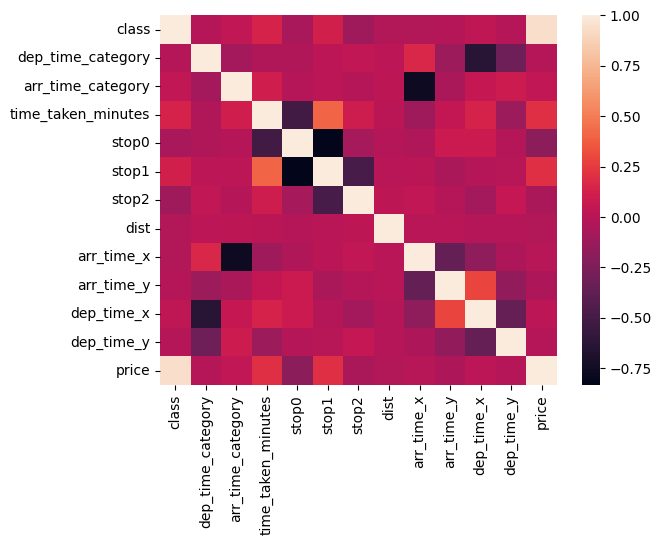

In [172]:
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr());

In [173]:
pd.DataFrame(pd.concat([X_train, y_train], axis=1).corr())

,class,dep_time_category,arr_time_category,time_taken_minutes,stop0,stop1,stop2,dist,arr_time_x,arr_time_y,dep_time_x,dep_time_y,price
class,1.000000,-0.020323,0.040046,0.139651,-0.068166,0.118533,-0.105900,-0.027567,-0.024478,-0.019072,0.033119,-0.022375,0.938257
dep_time_category,-0.020323,1.000000,-0.092548,-0.040761,-0.039830,0.015200,0.035585,0.012530,0.156380,-0.121007,-0.637225,-0.314229,-0.010840
arr_time_category,0.040046,-0.092548,1.000000,0.109866,-0.012389,0.018651,-0.014032,0.025487,-0.770871,-0.056496,0.055879,0.085197,0.039503
time_taken_minutes,0.139651,-0.040761,0.109866,1.000000,-0.514013,0.399151,0.093260,0.005509,-0.109868,0.047400,0.139339,-0.121594,0.204962
stop0,-0.068166,-0.039830,-0.012389,-0.514013,1.000000,-0.833230,-0.079229,-0.019533,-0.032905,0.076891,0.077758,-0.021519,-0.186555
stop1,0.118533,0.015200,0.018651,0.399151,-0.833230,1.000000,-0.485172,0.003070,0.008027,-0.058818,-0.020359,-0.007526,0.199171
stop2,-0.105900,0.035585,-0.014032,0.093260,-0.079229,-0.485172,1.000000,0.025355,0.037566,-0.015558,-0.086264,0.047599,-0.064055
dist,-0.027567,0.012530,0.025487,0.005509,-0.019533,0.003070,0.025355,1.000000,-0.001424,-0.000205,-0.016778,-0.017798,-0.025149
arr_time_x,-0.024478,0.156380,-0.770871,-0.109868,-0.032905,0.008027,0.037566,-0.001424,1.000000,-0.359079,-0.173729,-0.048557,-0.005102
arr_time_y,-0.019072,-0.121007,-0.056496,0.047400,0.076891,-0.058818,-0.015558,-0.000205,-0.359079,1.000000,0.287002,-0.164115,-0.047518


# Нормализация данных

Проведём нормализацию данных

In [174]:
time_taken_minutes_scaler = MinMaxScaler()
X_train['time_taken_minutes'] = \
time_taken_minutes_scaler.fit_transform(X_train[['time_taken_minutes']])
X_val['time_taken_minutes'] = \
time_taken_minutes_scaler.transform(X_val[['time_taken_minutes']])
X_test['time_taken_minutes'] = \
time_taken_minutes_scaler.transform(X_test[['time_taken_minutes']])

dist_scaler = MinMaxScaler()
X_train['dist'] = dist_scaler.fit_transform(X_train[['dist']])
X_val['dist'] = dist_scaler.transform(X_val[['dist']])
X_test['dist'] = dist_scaler.transform(X_test[['dist']])
X_val.head()

,class,dep_time_category,arr_time_category,time_taken_minutes,stop0,stop1,stop2,dist,arr_time_x,arr_time_y,dep_time_x,dep_time_y
65824,0.0,0,1,0.207815,0.0,1.0,0.0,1.000000,-0.675590,0.737277,0.896873,-0.442289
103216,0.0,1,1,0.323268,0.0,1.0,0.0,0.604520,-0.707107,0.707107,-0.258819,-0.965926
96403,0.0,1,1,0.031972,1.0,0.0,0.0,0.604520,-0.173648,-0.984808,-0.707107,-0.707107
208884,1.0,1,0,0.030195,1.0,0.0,0.0,1.000000,0.751840,-0.659346,0.258819,-0.965926
68445,0.0,1,1,0.147425,0.0,0.0,1.0,0.316384,0.480989,-0.876727,-0.999048,-0.043619


In [169]:
price_scaler = MinMaxScaler()
y_train['price'] = price_scaler.fit_transform(y_train[['price']])
y_val['price'] = price_scaler.transform(y_val[['price']])
y_test['price'] = price_scaler.transform(y_test[['price']])
y_test.head()

,price
54567,0.419619
180896,0.026850
217744,0.080298
215352,0.034740
104443,0.040864


# Подготовка датасета для нейронной сети

Создаём объекты для загрузки данных

In [175]:
class TicketsDataset(Dataset):
    def __init__(self, data_table: pd.DataFrame, targets: pd.DataFrame):
        self.data_table = data_table
        self.targets = targets
        assert self.data_table.shape[0] == self.targets.shape[0]
    def __len__(self):
        return self.targets.shape[0]
    def __getitem__(self, index):
        return Tensor(self.data_table.iloc[index]), Tensor(self.targets.iloc[index])

In [176]:
batch_size = 100

In [177]:
train_dataset = TicketsDataset(X_train, y_train)
val_dataset = TicketsDataset(X_val, y_val)
test_dataset = TicketsDataset(X_test, y_test)

In [178]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Создаём и обучаем нейронную сеть

In [192]:
class Network(Module):
    def __init__(self, n_of_features):
        super().__init__()
        hidden = 30
        self.layers = Sequential(
            Linear(n_of_features, hidden),
            Sigmoid(),
            Linear(hidden, 1)
        )
    def forward(self, x):
        return self.layers(x)

In [193]:
model = Network(X.shape[1])

In [194]:
loss_hist = []

In [195]:
epochs = 5

loss_fn = MSELoss()
#optim = Adam(model.parameters(), lr=0.001)
optim = SGD(model.parameters(), weight_decay=0.01)

for e in range(1, epochs + 1):
    for i, [data_input, target_output] in enumerate(train_dataloader):
        model.train()
        data_pred = model(data_input)
        loss = loss_fn(data_pred, target_output)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if (i + 1) % 10 == 0:
            print(f'Epoch: {e}, samples: {i * batch_size + len(data_input)}/{len(train_dataset)}, \
        loss={np.sqrt(loss.item())}')
    model.eval()
    data_input, target_output = next(iter(val_dataloader))
    data_pred = model(data_input)
    loss = loss_fn(data_pred, target_output)
    loss_hist.append(np.sqrt(loss.item()))

Epoch: 1, samples: 1000/134516,         loss=27706.97414009693
Epoch: 1, samples: 2000/134516,         loss=23229.012204568666
Epoch: 1, samples: 3000/134516,         loss=23711.491222611876
Epoch: 1, samples: 4000/134516,         loss=22865.362450658857
Epoch: 1, samples: 5000/134516,         loss=20347.97916256059
Epoch: 1, samples: 6000/134516,         loss=22742.46072877779
Epoch: 1, samples: 7000/134516,         loss=22608.82164112053
Epoch: 1, samples: 8000/134516,         loss=22949.819345694206
Epoch: 1, samples: 9000/134516,         loss=20966.239529300434
Epoch: 1, samples: 10000/134516,         loss=20835.162586358667
Epoch: 1, samples: 11000/134516,         loss=19603.414396476957
Epoch: 1, samples: 12000/134516,         loss=21092.27877684154
Epoch: 1, samples: 13000/134516,         loss=17421.5765073084
Epoch: 1, samples: 14000/134516,         loss=18488.168757343166
Epoch: 1, samples: 15000/134516,         loss=17069.803045143784
Epoch: 1, samples: 16000/134516,         

KeyboardInterrupt: 

In [ ]:
plt.plot(list(range(len(loss_hist))), loss_hist);

In [91]:
loss_hist

[8423.064525456279, 7873.06801698042]

In [208]:
features, target = next(iter(test_dataloader))
features

tensor([[ 0.0000,  1.0000,  1.0000,  0.1048,  0.0000,  1.0000,  0.0000,  0.8079,
         -0.5556, -0.8315, -0.8660,  0.5000]])

In [209]:
target

tensor([[4028.]])

In [210]:
model(features)

tensor([[6329.8228]], grad_fn=<AddmmBackward0>)

In [85]:
city_dists[city_indexes['Delhi']][city_indexes['Mumbai']]

1160

In [83]:
city_indexes['Delhi']

2

In [84]:
city_indexes['Mumbai']

5

In [ ]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/add-book', methods=['POST'])
def add_book():
    data = request.get_json()

    if not data:
        return jsonify({'error': 'No input data provided'}), 400

    position = data.get('position')
    positionTo = data.get('positionTo')
    classPlane = data.get('classPlane')

    # Логика обработки данных
    print(f"Position: {position}, PositionTo: {positionTo}, ClassPlane: {classPlane}")

    return jsonify({'message': 'Data received successfully'}), 200

if __name__ == '__main__':
    app.run(debug=True)